In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import datetime as dt
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
import re
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import KFold
import catboost
import lightgbm
import xgboost as xgb

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
from numpy import hstack
from numpy import vstack
from numpy import asarray
from sklearn.datasets import make_blobs
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import tensorflow_hub as hub

### Data

In [4]:
train = pd.read_csv("./custom_data/train_feature.csv")
test = pd.read_csv("./custom_data/test_feature.csv")
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [5]:
X = train.drop('problem', axis=1)
y = train['problem']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [7]:
# X_train = X
# y_train = y

### Scaler

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

### Super Learner

In [9]:
cat_params = {"logging_level" : "Silent"}
lgb_params = {'bagging_fraction': 0.9504775535991318, 'feature_fraction': 0.5598972214137229, 'lambda_l1': 2.9110070331408933, 'lambda_l2': 0.4065002276790508, 'learning_rate': 0.0118663823237834, 'max_depth': 12, 'min_child_samples': 19, 'min_child_weight': 35.21849812233922, 'min_samples_split': 0, 'min_split_gain': 0.05204638001792851, 'n_estimators': 949, 'num_leaves': 642, 'subsample': 0.5490080562116625}
xgb_params = {'gamma': 8.712501813678685, 'max_depth': 22, 'min_child_weight': 9.863337491640031, 'n_estimators': 106, 'reg_alpha': 0.032974405578371495, 'reg_lambda': 0.0006919861676045414}

In [10]:
def get_models():
    models = []
    models.append(catboost.CatBoostClassifier(**cat_params))
    models.append(LGBMClassifier(**lgb_params))
    models.append(xgb.XGBClassifier(**xgb_params))
    models.append(RandomForestClassifier())
    models.append(ExtraTreesClassifier())
    models.append(GradientBoostingClassifier())
    models.append(KNeighborsClassifier())
    models.append(GaussianNB())
    models.append(LinearDiscriminantAnalysis())
    models.append(GaussianProcessClassifier())
#     models.append(SVC(probability = True))
    return models

In [11]:
# collect out of fold predictions form k-fold cross validation
def get_out_of_fold_predictions(X, X_scaled, y, models):
    meta_X, meta_y = list(), list()
    kfold = KFold(n_splits=10, shuffle=True)
    fscores = np.zeros((10, len(models)))
    for total_idx, (train_ix, test_ix) in tqdm(enumerate(kfold.split(X))):
        fold_yhats = list()
        train_X, test_X = X[train_ix], X[test_ix]
        train_X_scaled, test_X_scaled = X_scaled[train_ix], X_scaled[test_ix]
        train_y, test_y = y[train_ix], y[test_ix]
        meta_y.extend(test_y)
        
        scores = []
        for model_idx, model in enumerate(models):
            if model_idx < 6: #####
                model.fit(train_X, train_y)
                yhat = model.predict_proba(test_X)
                fold_yhats.append(yhat)
                score = roc_auc_score(test_y, yhat[:, 1], average='micro')
                fscores[total_idx, model_idx] = score
            else:
                model.fit(train_X_scaled, train_y)
                yhat = model.predict_proba(test_X_scaled)
                fold_yhats.append(yhat)
                score = roc_auc_score(test_y, yhat[:, 1], average='micro')
                fscores[total_idx, model_idx] = score                
        meta_X.append(hstack(fold_yhats))
    return vstack(meta_X), asarray(meta_y), fscores
 
# fit all base models on the training dataset
def fit_base_models(X, X_scaled, y, models):
    for model_idx, model in enumerate(models):
        if model_idx < 4:
            model.fit(X, y)
        else:
            model.fit(X_scaled, y)
 
# fit a meta model
def fit_meta_model(X, y):
    model = LogisticRegression(solver='liblinear')
    model.fit(X, y)
    return model
 
# evaluate a list of models on a dataset
def evaluate_models(X, X_scaled, y, models):
    for model_idx, model in enumerate(models):
        if model_idx < 4:     
            yhat = model.predict_proba(X)[:,1]
            auc = roc_auc_score(y, yhat)
            print('%s: %.3f' % (model.__class__.__name__, auc*100))
        else:
            yhat = model.predict_proba(X_scaled)[:,1]
            auc = roc_auc_score(y, yhat)
            print('%s: %.3f' % (model.__class__.__name__, auc*100))
# make predictions with stacked model
def super_learner_predictions(X, X_scaled, models, meta_model):
    meta_X = list()
    for model_idx, model in enumerate(models):
        if model_idx < 4:
            yhat = model.predict_proba(X)
            meta_X.append(yhat)
        else:
            yhat = model.predict_proba(X_scaled)
            meta_X.append(yhat)
    meta_X = hstack(meta_X)
   # predict
    return meta_model.predict_proba(meta_X)[:,1]

In [12]:
models = get_models()

In [13]:
meta_X, meta_y, fscores = get_out_of_fold_predictions(X_train.values, X_scaled_train, y_train.values, models)

0it [00:00, ?it/s]

[15:24:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


1it [06:08, 368.02s/it]

[15:30:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


2it [12:23, 372.55s/it]

[15:36:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


3it [18:32, 370.82s/it]

[15:42:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


4it [24:42, 370.69s/it]

[15:48:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


5it [31:00, 373.17s/it]

[15:55:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


6it [37:20, 375.63s/it]

[16:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


7it [43:29, 373.34s/it]

[16:07:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


8it [49:37, 371.60s/it]

[16:13:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


9it [55:52, 372.64s/it]

[16:19:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


10it [1:01:59, 371.96s/it]


In [14]:
meta_model = fit_meta_model(meta_X, meta_y)

status|cat|lgb|xgb|rf
:---|:---:|:---:|:---:|:---:
tuning X|0.83847134|0.83117312|0.83468733|0.82470269
tuning O|----|0.83677207|0.832428|0.81877891
tuning O, n = 500|----|----|0.82202676|0.81936112|
tuning X, n = 100|----|----|----|----|

### 전체 데이터 재학습

In [15]:
fit_base_models(X_train, X_scaled_train ,y_train.values, models)

[16:26:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


### 성능 테스트

In [16]:
evaluate_models(X_test, X_scaled_test, y_test, models)

CatBoostClassifier: 83.982
LGBMClassifier: 83.951
XGBClassifier: 82.721
RandomForestClassifier: 81.939
ExtraTreesClassifier: 82.284
GradientBoostingClassifier: 82.953
KNeighborsClassifier: 75.251
GaussianNB: 75.744
LinearDiscriminantAnalysis: 79.454
GaussianProcessClassifier: 69.138


In [17]:
pd.DataFrame(fscores, columns=['cat', 'lgbm', 'xgb', 'rf', 'et', 'gbc', 'knn','nb','lda', 'gpc'])

,cat,lgbm,xgb,rf,et,gbc,knn,nb,lda,gpc
0,0.850683,0.852576,0.832342,0.833518,0.828708,0.845880,0.740730,0.789133,0.801696,0.702000
1,0.817521,0.816756,0.810055,0.801537,0.804823,0.804621,0.721297,0.745458,0.782696,0.687491
2,0.847416,0.848379,0.844254,0.834084,0.832917,0.837638,0.741864,0.772099,0.728302,0.705674
3,0.857766,0.853641,0.841624,0.840115,0.832015,0.844380,0.751396,0.762327,0.808420,0.721848
4,0.844876,0.846916,0.826593,0.844960,0.851612,0.837347,0.764447,0.809588,0.815889,0.725219
5,0.847067,0.843077,0.825959,0.820300,0.827807,0.840694,0.739894,0.757858,0.801014,0.684727
6,0.828447,0.823175,0.813080,0.821847,0.824978,0.825350,0.746112,0.763760,0.801266,0.683247
7,0.832283,0.831622,0.815158,0.817390,0.821615,0.825257,0.731330,0.751169,0.705707,0.702525
8,0.856538,0.856346,0.847444,0.845537,0.837299,0.859845,0.753720,0.783430,0.806245,0.693538
9,0.821685,0.825413,0.808336,0.803794,0.804480,0.817892,0.722582,0.743682,0.666563,0.678939


In [18]:
np.mean(fscores, axis=0)

array([0.8404283 , 0.83979015, 0.8264845 , 0.82630806, 0.82662555,
       0.83389046, 0.7413372 , 0.76785042, 0.77177974, 0.69852076])

### 최대성능

In [19]:
yhat = super_learner_predictions(X_test, X_scaled_test, models, meta_model)
roc_auc_score(y_test, yhat)

0.8436145322045181

### Submission

In [20]:
new_scaler = StandardScaler()
X_scaled = new_scaler.fit_transform(X)
test_scaled = scaler.transform(test)

In [21]:
yhat = super_learner_predictions(test, test_scaled, models, meta_model)

In [22]:
sample_submission['problem'] = yhat

In [23]:
sample_submission.to_csv('submission_0202_super_learner.csv', index=False)

(0.0, 7000.0)

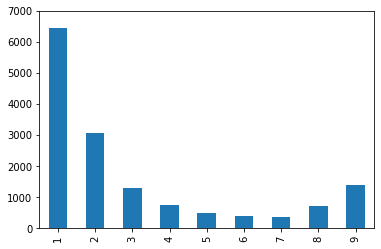

In [24]:
sample_submission['problem'].apply(lambda x: round(x*10)).value_counts().sort_index().plot.bar()
plt.ylim(0,7000)

In [25]:
sample_submission['problem'].apply(lambda x: round(x*1)).value_counts().sort_index()

0    11846
1     3153
Name: problem, dtype: int64